In [1]:
import numpy as np
import pandas as pd
import matplotlib
import anndata
import seaborn as sns
import scanpy as sc
from numpy.linalg import svd
from sklearn.cluster import KMeans

from dcv import *
import matplotlib.pyplot as plt

In [2]:
intens_df = loadmatfile('Dan_data/vesicles_data.mat')
mass_list = loadmat('Dan_data/acc_masses.mat')['acc_masses'][0]
names = loadmat('Dan_data/names.mat')['names'][0]

Loaded intensity matrix with shape (598, 96406)


In [3]:
# apply filters to select features with cell number

data_filtered = intens_df.iloc[:,intens_df.astype(bool).sum(axis=0).values>30]
data_filtered = data_filtered.iloc[:,data_filtered.columns>1100]

print('filtered intensity matrix with shape {}'.format(data_filtered.shape))

norm_factors = np.sqrt(np.mean(data_filtered.replace(0,np.NaN)**2,axis=1)).values
norm_factors = norm_factors.reshape(data_filtered.shape[0],1)
data_filtered = np.divide(data_filtered,norm_factors)
features = data_filtered.columns.values

data_filtered.head(10)

filtered intensity matrix with shape (598, 915)


,1100.04,1100.11,1100.98,1101.04,1101.13,1101.74,1101.77,1102.04,1102.13,1102.74,...,4255.50,4256.47,4256.49,4256.52,4257.47,4257.50,4258.49,4258.52,4259.47,4259.52
x_10003y_13694.d,0.000000,0.0,0.819403,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10183y_14705.d,0.000000,0.0,0.000000,0.000000,0.795605,0.0,0.000000,0.000000,0.458793,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10476y_13164.d,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10483y_13165.d,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.485709,0.0,0.0,0.0,0.0,0.0,0.0
x_10742y_10503.d,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10893y_10963.d,0.324248,0.0,0.526379,0.480864,0.000000,0.0,0.398035,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10915y_9313.d,1.151362,0.0,0.000000,2.905393,0.000000,0.0,0.000000,1.174873,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10920y_4720.d,0.000000,0.0,0.000000,0.000000,0.868677,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10963y_6633.d,0.128637,0.0,0.000000,0.193342,0.000000,0.0,0.077476,0.117891,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
x_10967y_10591.d,0.854776,0.0,0.000000,2.672690,0.000000,0.0,0.000000,1.669931,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


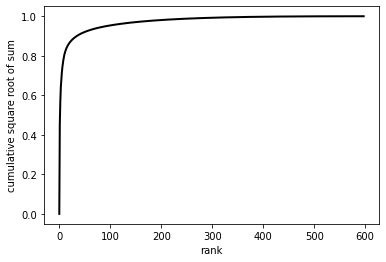

In [5]:
from numpy.linalg import svd

U,D,V = svd(data_filtered, full_matrices=False)
S_cumu = []

for i in range(len(D)):
    S_cumu.append(np.sqrt(np.sum(D[:i]**2))/np.sqrt(np.sum(D**2)))
fig= plt.figure()
plt.plot(S_cumu,c='k',linewidth=2)
plt.xlabel('rank')
plt.ylabel('cumulative square root of sum')
plt.show()

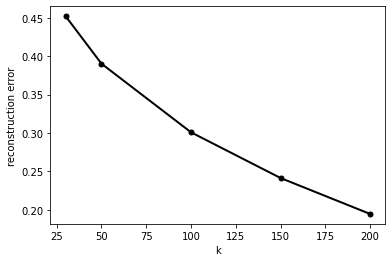

In [6]:
K = [30,50,100,150,200]
baseline = []
A = data_filtered.values
norm_X = np.linalg.norm(A, 'fro')
for k in K:
    proj = np.dot(U[:,:k], U[:,:k].T)
    Ak = np.dot(proj,A)
    baseline.append(np.linalg.norm(A - Ak, 'fro'))
    errors = baseline/norm_X
fig= plt.figure()
plt.plot(K,errors,c='k',linewidth=2,marker='.',markersize=10)
plt.xlabel('k');plt.ylabel('reconstruction error')
plt.show()

In [7]:
import random 

N = [100,150,200,250]
baseline_CX = []
baseline_CX_mean = []
baseline_CX_std = []

lev_150 = comp_lev(A,150,1)

for n in N:
    C, X, lev = cx_decomp(A, 100, n)
    p = lev/k
    baseline_CX.append(np.linalg.norm(A - np.dot(C,X), 'fro'))
    
    baseline_CX_sample = []
    for j in range(5):
        
        colInd = random.sample(list(np.linspace(0,A.shape[1]-1,A.shape[1]-1).astype(int)),n)

        C = np.dot(A[:,colInd], np.diag(1/p[colInd]))
        X = np.dot(np.linalg.pinv(C), A)
        baseline_CX_sample.append(np.linalg.norm(A - np.dot(C,X), 'fro'))
        
    baseline_CX_mean.append(np.mean(baseline_CX_sample))
    baseline_CX_std.append(np.std(baseline_CX_sample))
    
#     C, U, R = cur_decomp(A, 150, n,598)
#     baseline_CUR.append(np.linalg.norm(A - np.dot(np.dot(C,U),R), 'fro'))
    
errors_CX = baseline_CX/norm_X
baseline_CX_mean = baseline_CX_mean/norm_X
baseline_CX_std = baseline_CX_std/norm_X

errors_CX

array([0.36752533, 0.29772914, 0.24562445, 0.20251155])

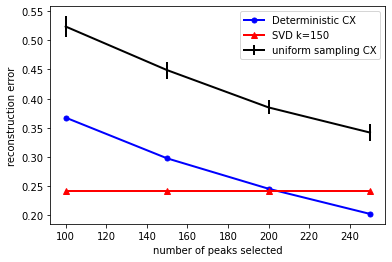

In [8]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.grid(False)
plt.plot(N,errors_CX,c='b',linewidth=2,marker='.',markersize=10,label='Deterministic CX')
plt.errorbar(N, baseline_CX_mean, baseline_CX_std, linewidth=2, marker=' ',c='k',markersize=6,label='uniform sampling CX')
plt.plot(N,[errors[3]]*len(N),c='r',linewidth=2,marker='^',markersize=6,label='SVD k=150')
plt.xlabel('number of peaks selected')
plt.ylabel('reconstruction error')
plt.legend()

(0.0, 1.0)

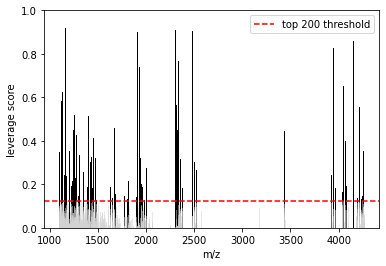

In [9]:
rank_idx = lev.argsort()[::-1]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.grid(False)

for j in range(200):
    plt.plot([features[rank_idx[j]],features[rank_idx[j]]], [0,lev[rank_idx[j]]], color='k',linewidth = 1)
for j in range(200,len(lev)):
    plt.plot([features[rank_idx[j]],features[rank_idx[j]]], [0,lev[rank_idx[j]]], color='lightgray',linewidth = 1,alpha=0.5)

plt.axhline(y = lev[lev.argsort()[::-1][200]], color='r',linestyle='--',label='top 200 threshold')
plt.legend()
plt.xlabel('m/z')
plt.ylabel('leverage score')
plt.ylim([0,1])

Text(0, 0.5, 'leverage score')

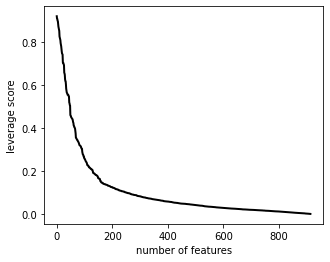

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.grid(False)
plt.plot(lev[rank_idx],color='k',linewidth = 2)
plt.xlabel('number of features')
plt.ylabel('leverage score')

In [11]:
def process(adata, n_pcs, min_dist, resolution):
    #sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)
    print('pca..')
    sc.tl.pca(adata, svd_solver='arpack')

    # print('getting neighbors..')
    # sc.pp.neighbors(adata, n_neighbors=15, metric='cosine', n_pcs=n_pcs)

    # print('leiden...')
    # sc.tl.leiden(adata, resolution=resolution)

#     sc.pl.umap(adata, color=['leiden', 'batch'])
#     sc.pl.pca(adata, color=['leiden', 'batch'])

data_selected = data_filtered.iloc[:,rank_idx[:200]]
features = data_selected.columns.values
X = (data_selected.loc[:, features].values)
adata = anndata.AnnData(X)

In [12]:
process(adata, n_pcs=15, min_dist=0.3, resolution = 0.6)

pca..


In [13]:
from sklearn.cluster import KMeans
# extract pca coordinates
X_pca = adata.obsm['X_pca'] 

# kmeans with k=3
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_pca) 
adata.obs['kmeans'] = kmeans.labels_.astype(str)

In [14]:
pca_df = pd.DataFrame(adata.obsm['X_pca'][:,:2],columns=['PC1','PC2'])
pca_df['cluster'] = adata.obs['kmeans'].values.astype(int)

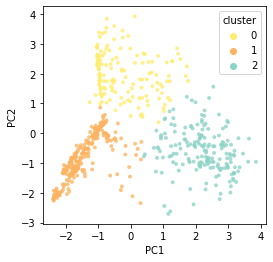

In [15]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.grid(False)
fig = sns.scatterplot(x='PC1', y='PC2', hue='cluster',data=pca_df,s=15,palette='Set3_r',linewidth=0,alpha=0.8)

... storing 'kmeans' as categorical


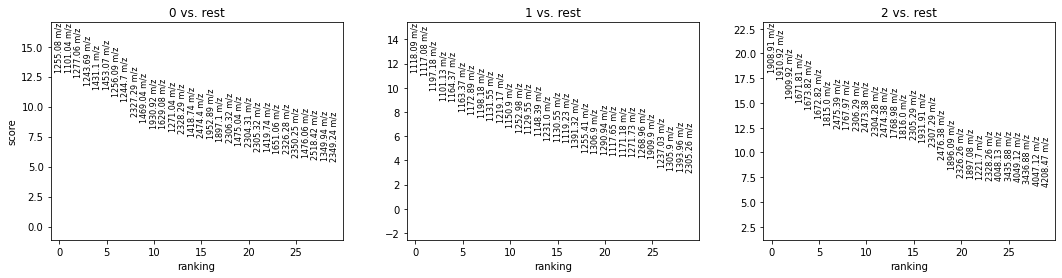

In [17]:
adata.var['mz'] = [a+' m/z' for a in features.astype(str)]
adata.var_names = [a+' m/z' for a in features.astype(str)]

sc.tl.rank_genes_groups(adata, 'kmeans', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False,gene_symbols='mz',save='wilcoxon.pdf')

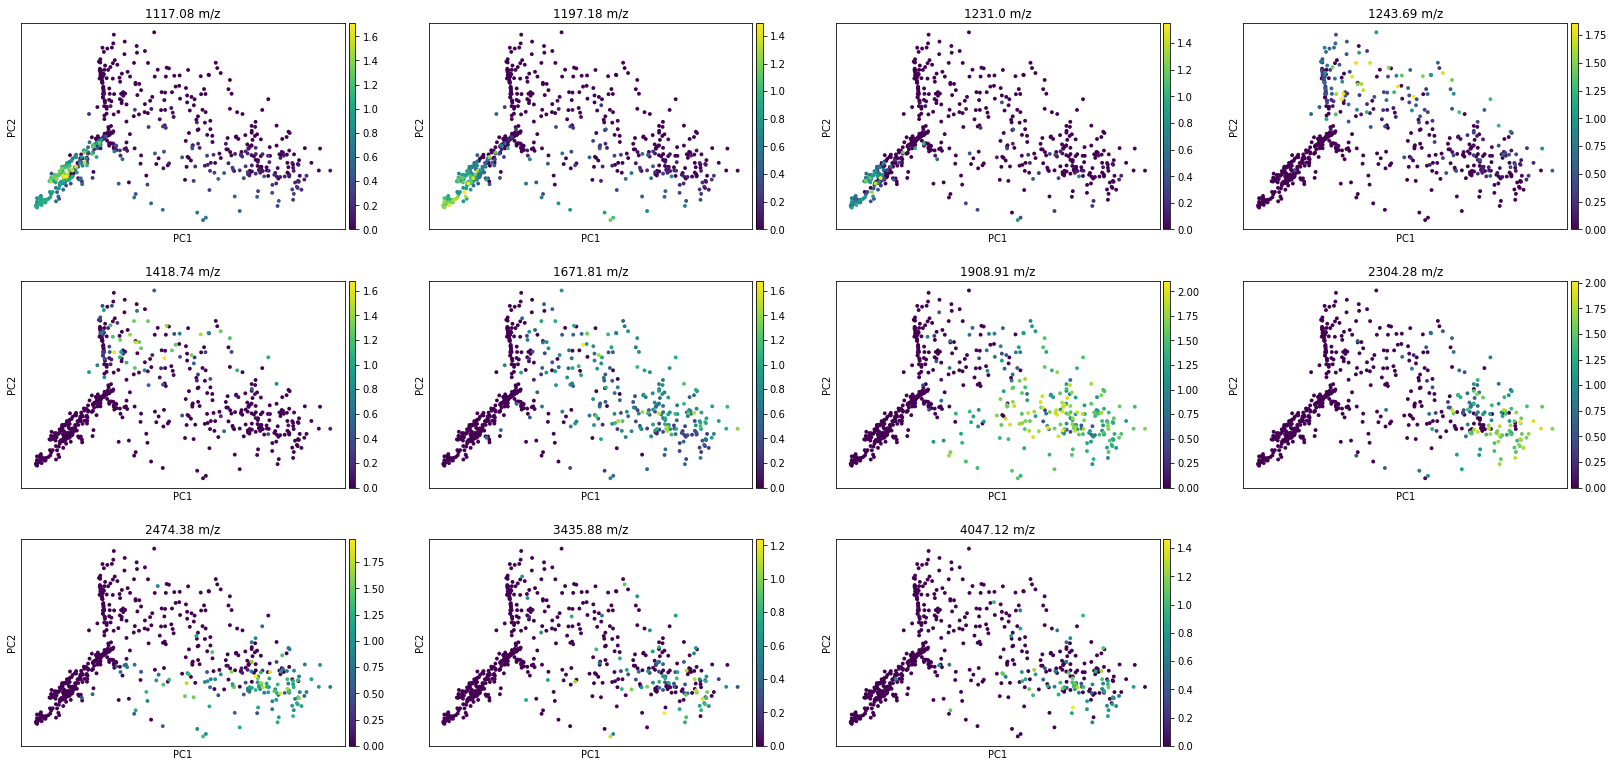

In [18]:
mzs = ['1117.08 m/z','1197.18 m/z','1231.0 m/z','1243.69 m/z','1418.74 m/z','1671.81 m/z','1908.91 m/z','2304.28 m/z','2474.38 m/z','3435.88 m/z','4047.12 m/z']

sc.pl.pca(adata, color=mzs,s=60,save='feature_plot.pdf')

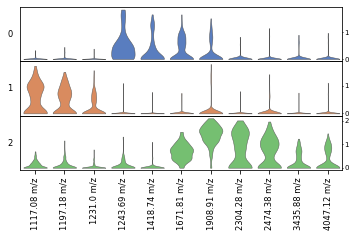

[<AxesSubplot:ylabel='2'>, <AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='0'>]

In [19]:
sc.pl.stacked_violin(adata, mzs, groupby='kmeans',figsize=(6,3),save='stackviolin.pdf')